# Imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

In [9]:
# Load the data
df = pd.read_csv('../data/preprocessed/walmart/walmart.csv')  # If you have it as a file
# Or use: df = pd.read_clipboard() if you've copied it to clipboard

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Filter data for stores 1 and 3
stores_to_plot = [1, 3]
filtered_df = df[df['Store'].isin(stores_to_plot)]

filtered_df.sample(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
46,1,2010-12-24,2387950.20,0,52.33,2.886,211.405122,7.838
141,1,2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
44,1,2010-12-10,1682614.26,0,46.33,2.843,211.465953,7.838
354,3,2011-05-27,369350.60,0,84.41,3.786,218.886077,7.574
363,3,2011-07-29,345381.29,0,88.07,3.682,218.844054,7.567
383,3,2011-12-16,510747.62,0,57.95,3.159,222.642642,7.197
21,1,2010-07-02,1492418.14,0,80.91,2.669,211.223533,7.787
348,3,2011-04-15,366250.69,0,75.88,3.743,218.678864,7.574
69,1,2011-06-03,1635078.41,0,83.00,3.699,215.273655,7.682


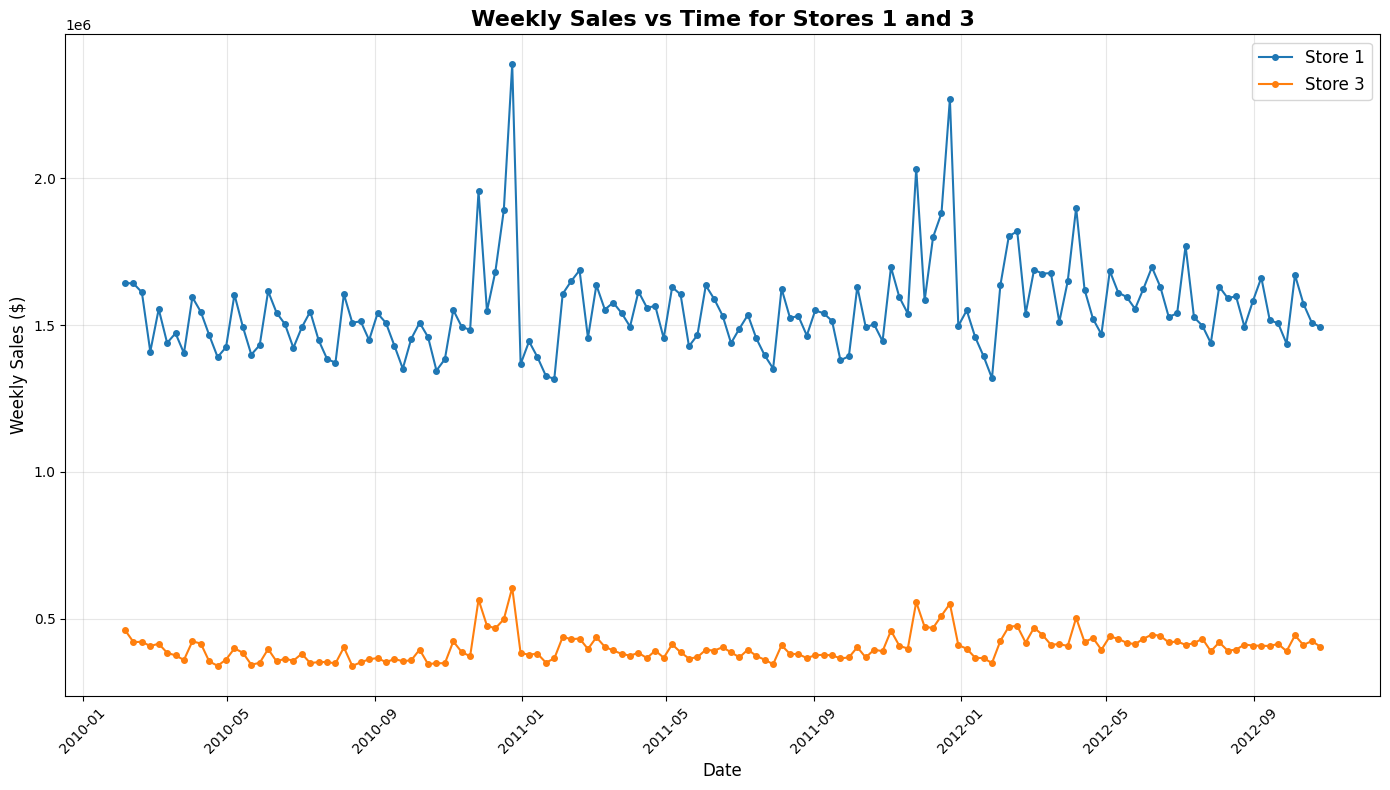

In [20]:
# Create a separate plot for each store
plt.figure(figsize=(14, 8))

for store in stores_to_plot:
    store_data = filtered_df[filtered_df['Store'] == store].sort_values('Date')
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], 
             marker='o', markersize=4, linewidth=1.5, label=f'Store {store}')

# Customize the plot
plt.title('Weekly Sales vs Time for Stores 1 and 3', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../figures/walmart_forecast_plots/sales_vs_time_1_3.png', dpi=300, bbox_inches='tight')

plt.show()

In [13]:
print(f"Date range for Store 1: {filtered_df[filtered_df['Store']==1]['Date'].min()} to {filtered_df[filtered_df['Store']==1]['Date'].max()}")
print(f"Date range for Store 3: {filtered_df[filtered_df['Store']==3]['Date'].min()} to {filtered_df[filtered_df['Store']==3]['Date'].max()}")
print(f"Number of weeks for Store 1: {len(filtered_df[filtered_df['Store']==1])}")
print(f"Number of weeks for Store 3: {len(filtered_df[filtered_df['Store']==3])}")

Date range for Store 1: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Date range for Store 3: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Number of weeks for Store 1: 143
Number of weeks for Store 3: 143



Decomposing Store 1...


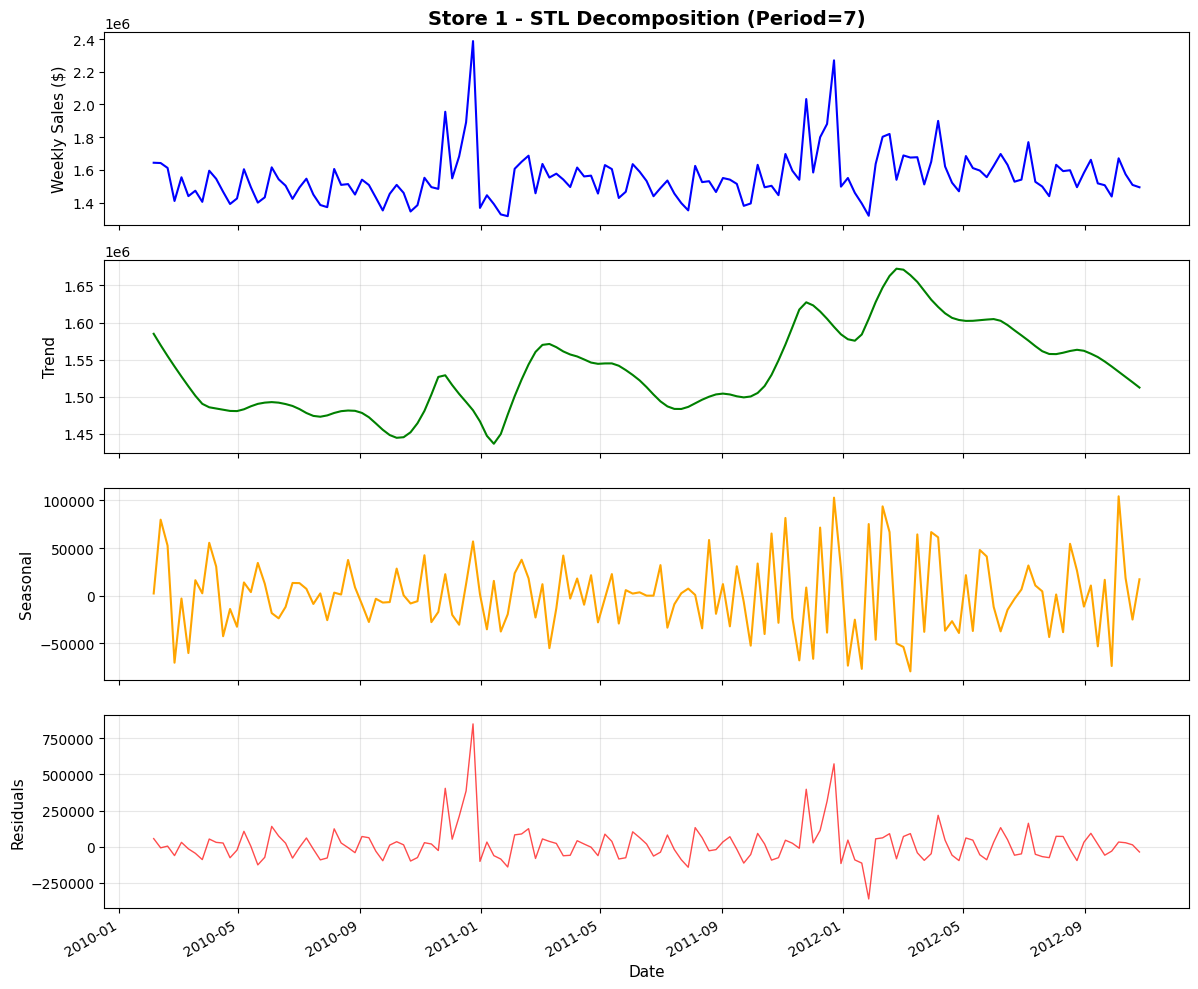


Decomposing Store 3...


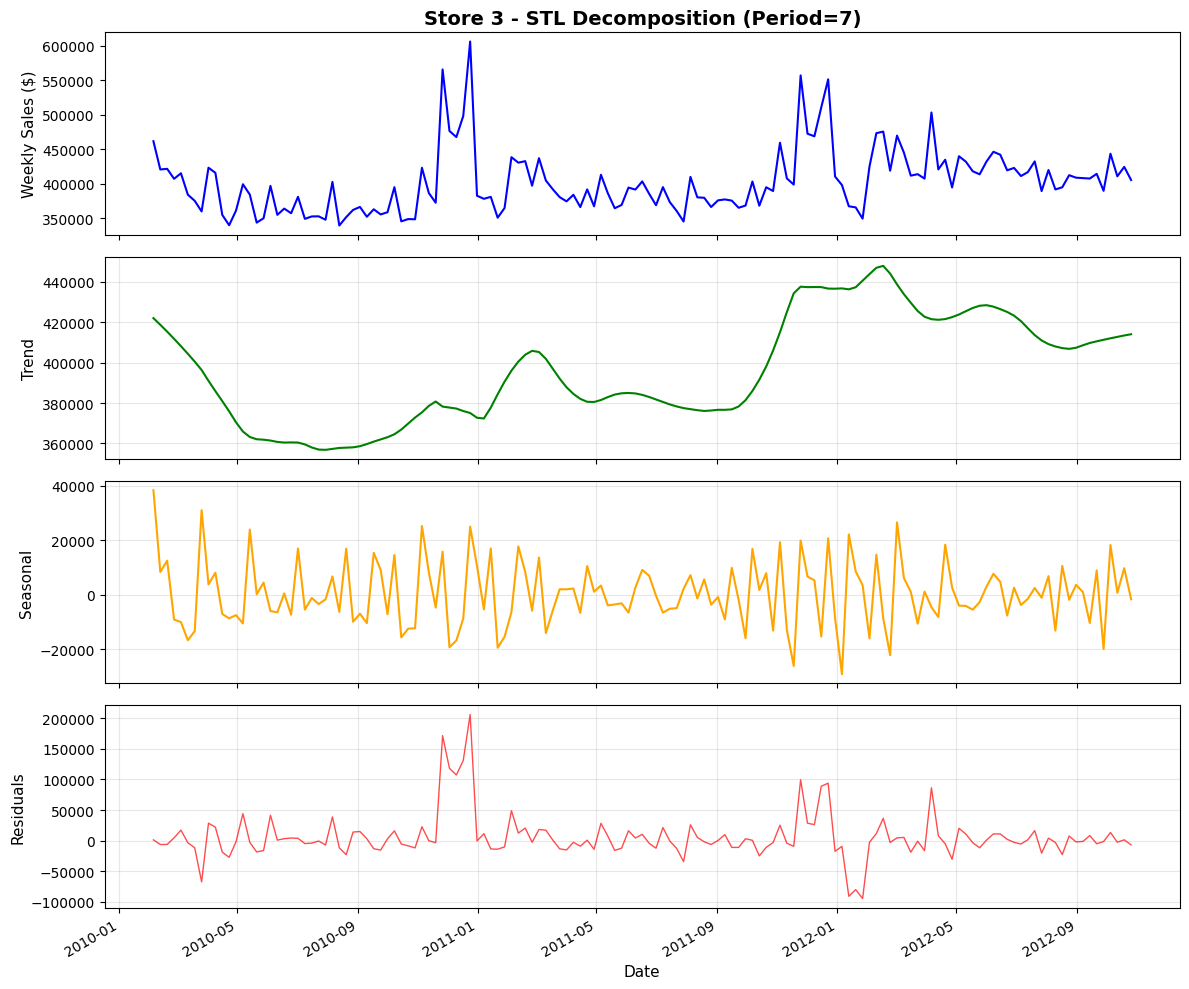


DECOMPOSITION SUMMARY

Store 1:
  Original Data: $1,555,264.40 mean, $155,980.77 std
  Trend: $1,535,770.96 mean
  Seasonal: Amplitude of $38,207.57
  Residuals: $18,897.41 mean, $130,965.35 std
  Seasonal Strength: 19.51%
  Trend Strength: 14.84%

Store 3:
  Original Data: $402,704.44 mean, $46,319.63 std
  Trend: $396,199.49 mean
  Seasonal: Amplitude of $11,899.93
  Residuals: $6,174.81 mean, $37,650.62 std
  Seasonal Strength: 28.15%
  Trend Strength: 10.03%


In [19]:
# Function to perform STL decomposition for a single store
def decompose_store_sales(store_id, period=52, figsize=(12, 10)):
    """Perform STL decomposition for a specific store."""
    # Get store data
    store_df = filtered_df[filtered_df['Store'] == store_id]
    
    # Set date as index
    store_series = store_df.set_index('Date')['Weekly_Sales']
    
    # Check if we have enough data points
    if len(store_series) < 2 * period:
        print(f"Warning: Store {store_id} has only {len(store_series)} data points, which is less than 2 * period ({2*period}). Consider reducing the period.")
    
    # Perform STL decomposition (weekly data with yearly seasonality - period=52)
    try:
        decomposition = STL(store_series, period=period, robust=True).fit()
    except Exception as e:
        print(f"Error decomposing Store {store_id}: {e}")
        # Try with smaller period if 52 fails
        period = min(period, len(store_series) // 2)
        print(f"Trying with period={period}")
        decomposition = STL(store_series, period=period, robust=True).fit()
    
    # Create plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=figsize)
    
    ax1.plot(decomposition.observed, color='blue', linewidth=1.5)
    ax1.set_ylabel('Weekly Sales ($)', fontsize=11)
    ax1.set_title(f'Store {store_id} - STL Decomposition (Period={period})', fontsize=14, fontweight='bold')
    
    ax2.plot(decomposition.trend, color='green', linewidth=1.5)
    ax2.set_ylabel('Trend', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    ax3.plot(decomposition.seasonal, color='orange', linewidth=1.5)
    ax3.set_ylabel('Seasonal', fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    ax4.plot(decomposition.resid, color='red', linewidth=1, alpha=0.7)
    ax4.set_ylabel('Residuals', fontsize=11)
    ax4.set_xlabel('Date', fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    # Format x-axis
    plt.xticks(rotation=45)
    fig.autofmt_xdate()
    plt.tight_layout()
    
    return fig, decomposition

# Decompose Store 1
print("\nDecomposing Store 1...")
fig1, decomp1 = decompose_store_sales(1, period=7)
plt.savefig('../figures/walmart_forecast_plots/store1_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Decompose Store 3
print("\nDecomposing Store 3...")
fig2, decomp2 = decompose_store_sales(3, period=7)
plt.savefig('../figures/walmart_forecast_plots/store3_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print summary statistics for both decompositions
print("\n" + "="*60)
print("DECOMPOSITION SUMMARY")
print("="*60)

for store_id, decomp in [(1, decomp1), (3, decomp2)]:
    print(f"\nStore {store_id}:")
    print(f"  Original Data: ${decomp.observed.mean():,.2f} mean, ${decomp.observed.std():,.2f} std")
    print(f"  Trend: ${decomp.trend.mean():,.2f} mean")
    print(f"  Seasonal: Amplitude of ${decomp.seasonal.std():,.2f}")
    print(f"  Residuals: ${decomp.resid.mean():,.2f} mean, ${decomp.resid.std():,.2f} std")
    
    # Calculate strength of components
    seasonal_strength = max(0, 1 - decomp.resid.var() / (decomp.trend + decomp.resid).var())
    trend_strength = max(0, 1 - decomp.resid.var() / (decomp.seasonal + decomp.resid).var())
    
    print(f"  Seasonal Strength: {seasonal_strength:.2%}")
    print(f"  Trend Strength: {trend_strength:.2%}")